In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import src.flow_ot as fo 
import importlib 

### 1. Test for Semi-Supervised Training Vector Operations

In [38]:
# set seed for reproducibility
np.random.seed(125)
# set array dimensions 
N = 4 # number of observations
M = 3 # dimension of an observation
K = 2 # number of classes
# simulate fake data
fake_y = np.random.randint(low = 0, high = 100, size = N * M * K).reshape((N * K, M))
fake_kern_y = np.random.randint(low = 0, high = 15, size = N * K * N * K).reshape((N * K, N * K))
fake_kern_z = np.random.randint(low = -10, high = 10, size = N * K * N * K).reshape((N * K, N * K))
fake_prob = np.random.randint(low = 0, high = 5, size = N * K).reshape((N, K))
fake_prob = (fake_prob.T / np.sum(fake_prob, axis = 1)).T # normalize

In [40]:
fake_y

array([[61, 29, 98],
       [87, 67, 77],
       [86, 43, 59],
       [64, 37, 86],
       [98, 95, 27],
       [30, 53, 58],
       [ 0, 84, 50],
       [89, 32, 87]])

In [41]:
fake_kern_y

array([[14,  2,  7, 12,  9, 14,  5,  3],
       [ 5, 12, 12,  7, 12,  9,  9,  1],
       [ 4,  4, 11, 14,  1,  6,  3,  1],
       [ 7,  4, 11,  9,  6, 14, 12,  7],
       [ 6,  1, 12, 10,  7,  4,  4, 11],
       [11,  2,  7,  5,  6,  8, 14, 11],
       [ 0,  3,  3, 10,  3,  9,  2,  4],
       [ 0,  0,  0,  1, 13, 12, 13,  9]])

In [71]:
# TODO: set the access data observation and class parameters
i = 1; k = 1;
# simulate "get_index" function 
l = i * K + k
print(f"The processed index is: {l}")
# reproduce gradient computation: the joint kernel derivative
print("\n\nCURRENTLY PROCESSING - joint kernels")
joint_prod = fake_kern_y[l, :] * fake_kern_z[l, :]
print(f"The product vectors on the (i={i}, k={k}) -> {l} entries are...", joint_prod)
weighted_diffs = (joint_prod * (fake_y[l, :] - fake_y).T).T
print(f"The weighted vector difference is\n", weighted_diffs)
summed_weights = np.sum(weighted_diffs, axis = 0)
print(f"Sum_weights:\n", summed_weights)
# check the summation of the kernel (i, k)s 
print(f"Sum of the kernel with respect to i, l: {np.sum(joint_prod)}")
# reproduce gradient computation: the singular kernel derivative 
print("\n\nCURRENTLY PROCESSING - singular y kernel")
weighted_diffs = (fake_kern_y[l, :] * (fake_y[l, :] - fake_y).T).T
print(f"The weighted vector difference is\n", weighted_diffs)

The processed index is: 3


CURRENTLY PROCESSING - joint kernels
The product vectors on the (i=1, k=1) -> 3 entries are... [-14 -40 -11  54  36   0 -96 -28]
The weighted vector difference is
 [[  -42  -112   168]
 [  920  1200  -360]
 [  242    66  -297]
 [    0     0     0]
 [-1224 -2088  2124]
 [    0     0     0]
 [-6144  4512 -3456]
 [  700  -140    28]]
Sum_weights:
 [-5548  3438 -1793]
Sum of the kernel with respect to i, l: -99


CURRENTLY PROCESSING - singular y kernel
The weighted vector difference is
 [[  21   56  -84]
 [ -92 -120   36]
 [-242  -66  297]
 [   0    0    0]
 [-204 -348  354]
 [ 476 -224  392]
 [ 768 -564  432]
 [-175   35   -7]]


In [75]:
print("CURRENTLY PROCESSING - probability weighted kernel")
weighted_kern_y = np.multiply(fake_prob.reshape((N * K, 1)), fake_kern_y)
print("Prob Weighted Kern:\n", weighted_kern_y)

CURRENTLY PROCESSING - probability weighted kernel
Prob Weighted Kern:
 [[11.2   1.6   5.6   9.6   7.2  11.2   4.    2.4 ]
 [ 1.    2.4   2.4   1.4   2.4   1.8   1.8   0.2 ]
 [ 3.    3.    8.25 10.5   0.75  4.5   2.25  0.75]
 [ 1.75  1.    2.75  2.25  1.5   3.5   3.    1.75]
 [ 6.    1.   12.   10.    7.    4.    4.   11.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.75  0.75  2.5   0.75  2.25  0.5   1.  ]
 [ 0.    0.    0.    0.75  9.75  9.    9.75  6.75]]


In [76]:
fake_prob[i, k] * np.sum(weighted_kern_y[l])

4.375

In [80]:
(fake_prob[i, :] * (weighted_kern_y[i * K:(i + 1) * K]).T).T

array([[2.25  , 2.25  , 6.1875, 7.875 , 0.5625, 3.375 , 1.6875, 0.5625],
       [0.4375, 0.25  , 0.6875, 0.5625, 0.375 , 0.875 , 0.75  , 0.4375]])

In [81]:
def estimate_p_ik(i, k, w_kern_y):
    l = i * K + k 
    return fake_prob[i, k] * np.sum(w_kern_y[l, :])

estimate_p_ik(i, k, weighted_kern_y) 

4.375

In [84]:
lst = [estimate_p_ik(i, k_prime, weighted_kern_y) for k_prime in np.arange(K)]

In [86]:
sum(lst)

29.125

### 2. Test using Real Data

In [74]:
# define a function to plot the kernel density estimation
def plot_densities(x_a, x_b, y): 
    """
    Visualize the kernel density estimations of the samples 
    from A, B, and the learned barycenter Y. 
    """
    _, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(data=x_a,
                color='crimson', label='A', fill=True, ax=ax)
    sns.kdeplot(data=x_b,
                color='limegreen', label='B', fill=True, ax=ax)
    sns.kdeplot(data=y,
                color='purple', label='Y', fill=True, ax=ax)
    ax.legend()
    plt.tight_layout()
    plt.show()
# generate samples from two 1-D gaussian distributions 
np.random.seed(125)
# set experiment parameters 
SAMPLE_SIZE = 10
NUM_CLASSES = 2
TOTAL_SIZE = NUM_CLASSES * SAMPLE_SIZE
MEAN_A = -1; SD_A = 1
MEAN_B = 1; SD_B = 1
# generate the x, labels, and y matrices 
x_a = np.random.normal(MEAN_A, SD_A, SAMPLE_SIZE)
x_b = np.random.normal(MEAN_B, SD_B, SAMPLE_SIZE)
x = np.concatenate((x_a, x_b)).reshape((TOTAL_SIZE, 1))
labels = np.zeros(TOTAL_SIZE, dtype=np.int64).reshape((TOTAL_SIZE, 1))
labels[SAMPLE_SIZE:] = 1
z_map = np.array([0, 1]).reshape((NUM_CLASSES, 1))
# determine the mask ratio
PERCENT_MASKED = 0.05
num_masked = int(PERCENT_MASKED * TOTAL_SIZE)
mask = np.random.choice(TOTAL_SIZE, num_masked, replace = False)
# mark the masked elements as '-1'
labels[mask] = -1

In [75]:
num_masked

1

In [76]:
labels

array([[ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [-1],
       [ 0],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1]])

In [78]:
# set-up the semi-supervised learner 
importlib.reload(fo)
ssl = fo.SemiSupervisedOT()
ssl.initialize(x, labels, NUM_CLASSES, z_map)
y = ssl.train(x, verbose = 5, growing_lambda=False, fixed_lam=150, max_iter = 5)

Iteration 1 Gradient Report:
[8.32667268e-15]
[8.32667268e-15]
[-1.66533454e-14]
[0.]

Probability Update for i=8: [0.5 0.5]
Iteration 2 Gradient Report:
[8.32667268e-15]
[8.32667268e-15]
[-1.66533454e-14]
[0.]

Probability Update for i=8: [0.5 0.5]
Iteration 3 Gradient Report:
[8.32667268e-15]
[8.32667268e-15]
[-1.66533454e-14]
[0.]

Probability Update for i=8: [0.5 0.5]
Iteration 4 Gradient Report:
[8.32667268e-15]
[8.32667268e-15]
[-1.66533454e-14]
[0.]

Probability Update for i=8: [0.5 0.5]
Iteration 5 Gradient Report:
[8.32667268e-15]
[8.32667268e-15]
[-1.66533454e-14]
[0.]

Probability Update for i=8: [0.5 0.5]
FINAL: Gradient norm = 2.980949547957902e-14 at iteration 5


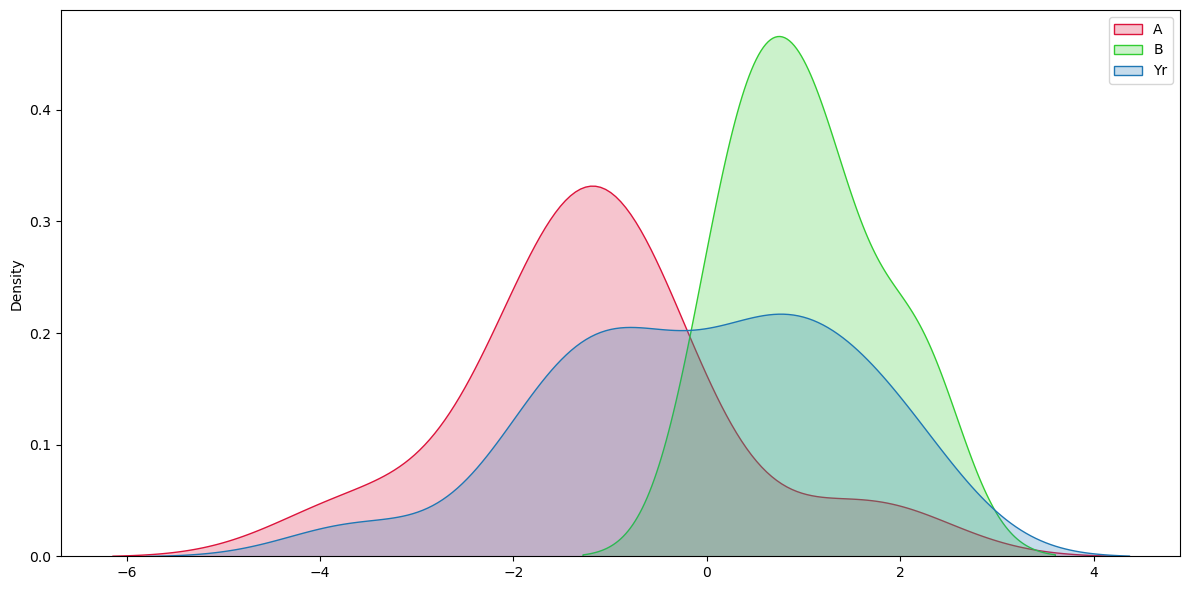

In [62]:
plot_densities(x_a, x_b, y)